# Training LeNet on MNIST with Caffee

A tutorial from the official Caffe library site:

http://caffe.berkeleyvision.org/gathered/examples/mnist.html

Shows how to set up and train the LeNet CNN architecture:

http://yann.lecun.com/exdb/mnist/

http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf

# Install packages

```
$ pip install lmdb
$ conda install caffe
$ conda install pydot # for draw-net.py
```

## Data Preparation

This network uses the MNIST training images. The official tutorial used some prebuilt binaries in order to download
and preprocess the data files into lmdb databases.  The exact commands used for data preparation preprocessing 
in the tutorial were:

```
cd $CAFFE_ROOT
./data/mnist/get_mnist.sh
./examples/mnist/create_mnist.sh
```

These require you have the full Caffe environment compiled and installed, and the shell scripts only run on
a unix/linux system.  If you look at these shell scripts, the get_mnist script simply downloads 
the gziped data from a remote location, and the create_mnist script is using some caffe binaries 
to create the lmdb database of the images.

Here we present an equivalent python script/code to convert the 10k test images and 50k training images in the
standard MNIST data set into an lmdb database suitable for training by Caffe.

We first load the same raw mnist data we were using for our deep learning textbook.

In [1]:
# first load the training images and correct outputs into numpy arrays for processing
import cPickle, gzip

f = gzip.open('../notebooks/data/mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = cPickle.load(f)
f.close()

As a reminder, the resulting data is simply a bunch of numpy arrays.  Each of the 3 variables 
`train_set`, `valid_set` and `test_set` are simply a tuple of two numpy arrays, the training imags
and the training labels for each one.  The training set contains 50,000 training images with labels,
the validation set contains another 10,000 images, and the test set also contains 10,000 images.  We
will only use the training set for training, and the test set to test our training performance in
this tutorial.

In [2]:
# just a reminder, each of the above is a tuple of numpy.ndarrays.  For example, the train_set
# is a tuple of inputs x and outputs y.
train_images, train_labels = train_set
test_images, test_labels = test_set

print type(train_images), len(train_images)
print type(train_labels), len(train_labels)

# the inputs are 784 length greyscale values of the original 28x28 input images
print train_images.shape

# but the outputs are encoded as a single decimal number 0-9, which we will have to convert into a one-hot vector
print train_labels.shape

<type 'numpy.ndarray'> 50000
<type 'numpy.ndarray'> 50000
(50000, 784)
(50000,)


One slight adjustment we need for our data.  The LeNet network definition we are using from the Caffe tutorial
basically assumes that the images are shaped as 28x28 pixel images (easy enough to fix), but also assumes that
each pixel is represented as an unsigned integer values (e.g. a value with 8 bits, ranging from 0 to 255).  So
we first reshape and recast the train_images and test_images to the required shape and type.

In [3]:
import numpy as np

# the pixel values are in range 0.0 - 1.0, recast them into range 0.0 - 255.0
train_images *= 255.0
test_images *= 255.0

# now we reshape and recast into an unsigned int data type, for storage in the lmdb database
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
train_images = train_images.reshape(len(train_labels), IMAGE_WIDTH, IMAGE_HEIGHT).astype(np.uint8)
test_images = test_images.reshape(len(test_labels), IMAGE_WIDTH, IMAGE_HEIGHT).astype(np.uint8)

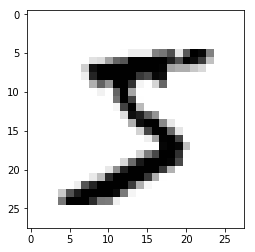

In [4]:
# lets just show the first training image after converting to uint8
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(train_images[0,:,:], cmap=plt.cm.gray_r)

It is apparently common practice for Caffe work to place all of the images in either a lmdb or leveldb
database.  These are high performance databases, optimized to reduce disk I/O so can train with large data
sets and not have to store complete set of images in the core memory.
[Here](http://deepdish.io/2015/04/28/creating-lmdb-in-python/) is a quick description of
the lmdb database usage.  

Here we write some quick and dirty code to create  lmdb databases holding the training and testing data
respecrively, and write each of our images with its corresponding label into the database.  Apparently 
Caffe stores the label as a simple integer in the database, and then internally it takes care of converting
the final layer of 10 outputs as a one-hot vector representation to compare with the integer label we store
here in the lmdb database.


In [7]:
import caffe
from caffe.proto import caffe_pb2
import lmdb

# put all train images/labels in train_lmdb database
train_lmdb = 'data/mnist/train_lmdb'
in_db = lmdb.open(train_lmdb, map_size=int(1e12))
with in_db.begin(write=True) as in_txn:
    for idx, img in enumerate(train_images):
        datum = caffe_pb2.Datum()
        datum.channels = 1
        datum.height = 28
        datum.width = 28
        datum.data = img.tobytes()
        datum.label = train_labels[idx]        
        str_id = '{:08}'.format(idx)
        in_txn.put(str_id, datum.SerializeToString())
in_db.close()

# now put all test images/labels in test_lmdb database
test_lmdb = 'data/mnist/test_lmdb'
in_db = lmdb.open(test_lmdb, map_size=int(1e12))
with in_db.begin(write=True) as in_txn:
    for idx, img in enumerate(test_images):
        datum = caffe_pb2.Datum()
        datum.channels = 1
        datum.height = 28
        datum.width = 28
        datum.data = img.tobytes()
        datum.label = test_labels[idx]        
        str_id = '{:08}'.format(idx)
        in_txn.put(str_id, datum.SerializeToString())
in_db.close()

## Model Definition

Caffe models are defined in a prototxt format file.  The prototxt is the 
[Google Protocol Buffer](https://developers.google.com/protocol-buffers/) format, which
is a kind of lightweight XML defintion for serializing structured data in plain text files.  The LeNet network
Cafee model is in the data/caffe_models/lenet_model subdirectory.  You can visualize the network using the 
draw-net.py tool (copied from the Caffe distribution into our cluster repository subdirectory):

![LeNet Model](lenet_model.png)

The neural network model architecture is defined in the lenet_train_test.prototxt file.  As sown in the diagram,
it consists of 5x5 convolutional layer and 2x2 pool layer (conv1, pool1) producing 20 output/feature 
detectors, followed by another convolutional/pool layer (conv2, pool2), which is also a 5x5 convolution and
2x2 pool outputing 50 features from this second convolution.  There is then a fully connected layer with 500
units in it (ip1 and relu1, so this layer is using a rectified linear output activation function).  Followed
by layer ip2 with 10 output units, representing the final classification, where the ip2 layer uses the Softmax
output activation function.

The cell below runs the draw-net.py tool to generate the image visualization of the network.  The following
cell is running the script from the linux/unix command line.  You may need to modify this cell to run it
on a windows machine (e.g. try simply calling python draw-net.py ...):

In [ ]:
!./draw-net.py data/caffe_models/lenet_model/lenet_train_test.prototxt lenet_model.png

## Model Training

The Caffe solver file for this tutorial is defined to perform 10,000 training iterations on the network.  The next
line runs the trainer to create the network model and train it on our mnist lmbd database data.
Again this next line is running a command line tool on a linux/unix system, it may not run on your personal
laptop unless you have successfully installed caffe, and even then you may need to find the path to the caffe
binary or set your system path to include this binary.
The statistics from the training on the model and data are saved in the lenet_train.log file.  We can parse
this file in the next cell to visualize the performance of the network training.

The solver file contains the metaparameters used for the neural network training session.  In this
training session we start out with a base learning rate of 0.001 (different from the tutorial), as 0.01
was learning a bit too fast on our system and was unstable at times.  We train for a total of 10000 iterations.
On our cluster system, this will usually take about 30 minutes to train for 10 iterations, at which point we
usually achieve an accuracy of almost 0.99 (99%) on the test data.

In [ ]:
!caffe train --solver=data/caffe_models/lenet_model/lenet_solver.prototxt 2>&1 | tee data/caffe_models/lenet_model/lenet_train.log

## Visualize Training Results

![Learning Results](lenet_learningcurves.png)

The following cell will parse the training performance log produced by caffe and display the training and test
loss (e.g. the cost or objective function), as well as the training accuracy (as a ratio between 0.0 and 1.0).
Again this cell has commands/scripts meant to be run from the command line.  The first two commands parse the
log file for training and testing performance data respectively.  The last command creates the image file
which is a standard plot of loss/accuracy over the training iterations of this training run.

In [ ]:
!./parse-caffe-log.py --train data/caffe_models/lenet_model/lenet_train.log > lenet_train.log.train
!./parse-caffe-log.py --test data/caffe_models/lenet_model/lenet_train.log > lenet_train.log.test
!./plot-learning-curves.py --train lenet_train.log.train --test lenet_train.log.test --outfile lenet_learningcurves.png

# Prediction on New Data

This is not in the original tutorial, but lets try out the trained model on some new data we will create.

First of all, in the data/new-mnist-images subdirectory I've added a couple of png images of my own handwriting.
Feel free to take some images of your own written digits and also try.  In the next cell we load a single
image, then we scale it to be 28x28 size and convert it into the unsigned 8 bit integer single channel values
we need for input.

In [1]:
# need opencv2 to read in image
# by default, reading in as IMREAD_GRAYSCALE will read as unsigned 8 bit values
import cv2

img_path = 'data/new-mnist-images/derek-image-3.png'
#img_path = 'data/new-mnist-images/derek-image-6.png' # some other images to try
#img_path = 'data/new-mnist-images/derek-image-8.png' # some other images to try

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = (255 - img) # invert black/white, because reversed for some reason in the color png from what we want

print type(img)
print img.shape
print img.dtype
print img

<type 'numpy.ndarray'>
(900, 872)
uint8
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [2]:
# resize image to desired shape
IMAGE_WIDTH=28
IMAGE_HEIGHT=28

img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_CUBIC)

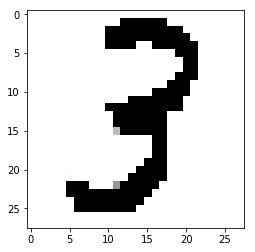

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img, cmap=plt.cm.gray_r)

In [ ]:
import caffe
from caffe.proto import caffe_pb2

# Read model architecture and the trained model's weights
net = caffe.Net('data/caffe_models/lenet_model/lenet_deploy.prototxt',
                'data/mnist/lenet_iter_10000.caffemodel',
                caffe.TEST)